#  ONS Census 2021 Report Ethnicity Geo-Targeting

The motivation of this analysis is to harness the 2021 ONS Census report of ethnicities within the UK and provide a geo-strategy for targeting select groups. 

This notebook utilises Pandas, Re, GeoPandas, and Matplotlib to load and manipulate the report's data, produce % penetration scores for ethnicities within Local Authorities, and map these thematically via heat maps using geospatial references.

### Set-up

In [57]:
# Required libraries/imports:
import os
import pandas as pd
import re
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import LineString
from shapely.ops import linemerge
from shapely.geometry import Polygon
from geopandas import GeoDataFrame
from shapely.geometry import box
from geopandas.tools import sjoin
from shapely.geometry import MultiPolygon
from shapely.geometry import MultiLineString

### Loading Data

In [65]:
# Get the path of the current directory
current_dir = os.getcwd()

# Construct a relative path to the Excel file
excel_filename = "TS022-2021-1.xlsx"
excel_path = os.path.join(current_dir, excel_filename)

# Read Census file into a DataFrame
xl = pd.ExcelFile(excel_path)

# List sheets available
print('Excel Sheet Names:',xl.sheet_names)
print(' ')

# List field names within Census DataFrame
census_raw = xl.parse('Dataset')
print('Dataset field names:')
for col in census_raw.columns:
    print(col)

C:\Users\Jonny.Lankfer\TS022-2021-1.xlsx


### Pre-processing

In [3]:
# Sum observations within authority
authority_total = census_raw.loc[:, ["Lower Tier Local Authorities Code","Observation"]].groupby(['Lower Tier Local Authorities Code'],as_index = False).sum()

# Print the resulting DataFrame
display(authority_total)

,Lower Tier Local Authorities Code,Observation
0,E06000001,92335
1,E06000002,143916
2,E06000003,136525
3,E06000004,196596
4,E06000005,107792
...,...,...
326,W06000020,92278
327,W06000021,92963
328,W06000022,159588
329,W06000023,133175


In [4]:
# Sum of observations within authority by ethnicity group 
authority_ethnicity = census_raw.loc[:, ["Lower Tier Local Authorities Code","Ethnic Group (detailed) (288 categories) Code","Observation"]].groupby(['Lower Tier Local Authorities Code','Ethnic Group (detailed) (288 categories) Code'],as_index = False).sum().pivot('Lower Tier Local Authorities Code','Ethnic Group (detailed) (288 categories) Code').fillna(0)
authority_ethnicity['Lower Tier Local Authorities Code'] = authority_ethnicity.index
cols = list(authority_ethnicity.columns)
cols = [cols[-1]] + cols[:-1]
authority_ethnicity = authority_ethnicity[cols]

# Print the resulting DataFrame
display(authority_ethnicity)

Lower Tier Local Authorities Code  \
Ethnic Group (detailed) (288 categories) Code                                     
Lower Tier Local Authorities Code                                                 
E06000001                                                             E06000001   
E06000002                                                             E06000002   
E06000003                                                             E06000003   
E06000004                                                             E06000004   
E06000005                                                             E06000005   
...                                                                         ...   
W06000020                                                             W06000020   
W06000021                                                             W06000021   
W06000022                                                             W06000022   
W06000023                                                             W06000023   
W06000024                                                             W06000024   

                                              Observation                     \
Ethnic Group (detailed) (288 categories) Code          -8    1  2   3  4   5   
Lower Tier Local Authorities Code                                              
E06000001                                               0    2  0   0  0  15   
E06000002                                               0  374  2   2  1  48   
E06000003                                               0   18  0   5  0   2   
E06000004                                               0   42  4  15  1   2   
E06000005                                               0    1  0   1  0   9   
...                                                   ...  ... ..  .. ..  ..   
W06000020                                               0    0  0   2  1   1   
W06000021                                               0    0  0   2  1   5   
W06000022                                               0  108  8   1  6  36   
W06000023                                               0    3  0   2  0   0   
W06000024                                               0    1  0   0  0   1   

                                                            ...              \
Ethnic Group (detailed) (288 categories) Code   6     7  8  ... 278 279 280   
Lower Tier Local Authorities Code                           ...               
E06000001                                       2   278  0  ...   1   0   2   
E06000002                                      44   595  1  ...   4   6  24   
E06000003                                      16   158  1  ...   2   3   6   
E06000004                                      28   236  2  ...  10  18   6   
E06000005                                       9   759  0  ...   1   4   6   
...                                            ..   ... ..  ...  ..  ..  ..   
W06000020                                       3    99  0  ...   1   2   7   
W06000021                                      10    52  0  ...   1   2   0   
W06000022                                      54  2858  0  ...   3   2   4   
W06000023                                      13    79  0  ...   3   2   0   
W06000024                                       1    46  1  ...   2   0   0   

                                                                             
Ethnic Group (detailed) (288 categories) Code 281 282  283 284 285 286  287  
Lower Tier Local Authorities Code                                            
E06000001                                      14   3   24   1   0   1   22  
E06000002                                      25   6   26   1   6   2  121  
E06000003                                       7   3   15   1   0   0   27  
E06000004                                      18   0   27   1   0   3   90  
E06000005                                      18   4   26   0   0   2   62  
...                            

In [5]:
# Merge total and pivoted DFs on Authority Code as pretense for feature engineering
merged_authority = authority_ethnicity.merge(authority_total, how='inner', on=authority_ethnicity['Lower Tier Local Authorities Code'], left_index=False, right_index=False, sort=True, suffixes=('_x', '_y'), copy=True).iloc[: , 1:]
cols = list(merged_authority.columns)
cols = [cols[:-2]] + [cols[-1]]

# Print the resulting DataFrame
display(merged_authority)

# Print field's classes (reference Object & integers positioning)
result = merged_authority.dtypes
print("Output:")
print(result)

C:\Users\Jonny.Lankfer\AppData\Local\Temp\ipykernel_16908\964472243.py:2: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  merged_authority = authority_ethnicity.merge(authority_total, how='inner', on=authority_ethnicity['Lower Tier Local Authorities Code'], left_index=False, right_index=False, sort=True, suffixes=('_x', '_y'), copy=True).iloc[: , 1:]


,"(Lower Tier Local Authorities Code, )","(Observation, -8)","(Observation, 1)","(Observation, 2)","(Observation, 3)","(Observation, 4)","(Observation, 5)","(Observation, 6)","(Observation, 7)","(Observation, 8)",...,"(Observation, 280)","(Observation, 281)","(Observation, 282)","(Observation, 283)","(Observation, 284)","(Observation, 285)","(Observation, 286)","(Observation, 287)",Lower Tier Local Authorities Code,Observation
0,E06000001,0,2,0,0,0,15,2,278,0,...,2,14,3,24,1,0,1,22,E06000001,92335
1,E06000002,0,374,2,2,1,48,44,595,1,...,24,25,6,26,1,6,2,121,E06000002,143916
2,E06000003,0,18,0,5,0,2,16,158,1,...,6,7,3,15,1,0,0,27,E06000003,136525
3,E06000004,0,42,4,15,1,2,28,236,2,...,6,18,0,27,1,0,3,90,E06000004,196596
4,E06000005,0,1,0,1,0,9,9,759,0,...,6,18,4,26,0,0,2,62,E06000005,107792
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326,W06000020,0,0,0,2,1,1,3,99,0,...,7,0,0,8,0,2,2,20,W06000020,92278
327,W06000021,0,0,0,2,1,5,10,52,0,...,0,0,1,28,1,2,3,33,W06000021,92963
328,W06000022,0,108,8,1,6,36,54,2858,0,...,4,3,1,158,0,2,6,245,W06000022,159588
329,W06000023,0,3,0,2,0,0,13,79,0,...,0,2,0,20,2,0,1,27,W06000023,133175


Output:
(Lower Tier Local Authorities Code, )    object
(Observation, -8)                         int64
(Observation, 1)                          int64
(Observation, 2)                          int64
(Observation, 3)                          int64
                                          ...  
(Observation, 285)                        int64
(Observation, 286)                        int64
(Observation, 287)                        int64
Lower Tier Local Authorities Code        object
Observation                               int64
Length: 291, dtype: object


### Feature Engineering

In [6]:
# Feature engineering => calculate penetration % (float) used for thematic mapping
for column in merged_authority.columns[1:-2]:
    merged_authority[column] = round((merged_authority[column] / merged_authority[merged_authority.columns[-1]])*100,2)

# Print the resulting DataFrame
display(merged_authority)

,"(Lower Tier Local Authorities Code, )","(Observation, -8)","(Observation, 1)","(Observation, 2)","(Observation, 3)","(Observation, 4)","(Observation, 5)","(Observation, 6)","(Observation, 7)","(Observation, 8)",...,"(Observation, 280)","(Observation, 281)","(Observation, 282)","(Observation, 283)","(Observation, 284)","(Observation, 285)","(Observation, 286)","(Observation, 287)",Lower Tier Local Authorities Code,Observation
0,E06000001,0.0,0.00,0.00,0.00,0.0,0.02,0.00,0.30,0.0,...,0.00,0.02,0.00,0.03,0.0,0.00,0.0,0.02,E06000001,92335
1,E06000002,0.0,0.26,0.00,0.00,0.0,0.03,0.03,0.41,0.0,...,0.02,0.02,0.00,0.02,0.0,0.00,0.0,0.08,E06000002,143916
2,E06000003,0.0,0.01,0.00,0.00,0.0,0.00,0.01,0.12,0.0,...,0.00,0.01,0.00,0.01,0.0,0.00,0.0,0.02,E06000003,136525
3,E06000004,0.0,0.02,0.00,0.01,0.0,0.00,0.01,0.12,0.0,...,0.00,0.01,0.00,0.01,0.0,0.00,0.0,0.05,E06000004,196596
4,E06000005,0.0,0.00,0.00,0.00,0.0,0.01,0.01,0.70,0.0,...,0.01,0.02,0.00,0.02,0.0,0.00,0.0,0.06,E06000005,107792
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326,W06000020,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.11,0.0,...,0.01,0.00,0.00,0.01,0.0,0.00,0.0,0.02,W06000020,92278
327,W06000021,0.0,0.00,0.00,0.00,0.0,0.01,0.01,0.06,0.0,...,0.00,0.00,0.00,0.03,0.0,0.00,0.0,0.04,W06000021,92963
328,W06000022,0.0,0.07,0.01,0.00,0.0,0.02,0.03,1.79,0.0,...,0.00,0.00,0.00,0.10,0.0,0.00,0.0,0.15,W06000022,159588
329,W06000023,0.0,0.00,0.00,0.00,0.0,0.00,0.01,0.06,0.0,...,0.00,0.00,0.00,0.02,0.0,0.00,0.0,0.02,W06000023,133175


### Further Data Cleansing

In [7]:
# Data Cleansing => function creation to rename ethnicity by code value, re-apply naming convention, and cast % penetration as float
def remove_non_numeric_chars(df):
    
    # Remove non-numeric characters from field name
    df.columns = [re.sub(r'\D', '', str(col)) for col in df.columns]
    
    # Re-append field names where removed from prior condition
    df.columns = [*df.columns[:-1], 'Total Observations']
    df.rename(columns={ df.columns[0]: "Lower Tier Local Authorities Code" }, inplace = True)
    
    # Cast % penetration scores as float
    df.iloc[:, 1:-2] = df.iloc[:, 1:-2].astype(float)
    
    return df

# Apply cleansing function to DataFrame
remove_non_numeric_chars(merged_authority)

,Lower Tier Local Authorities Code,8,1,2,3,4,5,6,7,8,...,280,281,282,283,284,285,286,287,Lower Tier Local Authorities Code,Total Observations
0,E06000001,0.0,0.00,0.00,0.00,0.0,0.02,0.00,0.30,0.0,...,0.00,0.02,0.00,0.03,0.0,0.00,0.0,0.02,E06000001,92335
1,E06000002,0.0,0.26,0.00,0.00,0.0,0.03,0.03,0.41,0.0,...,0.02,0.02,0.00,0.02,0.0,0.00,0.0,0.08,E06000002,143916
2,E06000003,0.0,0.01,0.00,0.00,0.0,0.00,0.01,0.12,0.0,...,0.00,0.01,0.00,0.01,0.0,0.00,0.0,0.02,E06000003,136525
3,E06000004,0.0,0.02,0.00,0.01,0.0,0.00,0.01,0.12,0.0,...,0.00,0.01,0.00,0.01,0.0,0.00,0.0,0.05,E06000004,196596
4,E06000005,0.0,0.00,0.00,0.00,0.0,0.01,0.01,0.70,0.0,...,0.01,0.02,0.00,0.02,0.0,0.00,0.0,0.06,E06000005,107792
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326,W06000020,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.11,0.0,...,0.01,0.00,0.00,0.01,0.0,0.00,0.0,0.02,W06000020,92278
327,W06000021,0.0,0.00,0.00,0.00,0.0,0.01,0.01,0.06,0.0,...,0.00,0.00,0.00,0.03,0.0,0.00,0.0,0.04,W06000021,92963
328,W06000022,0.0,0.07,0.01,0.00,0.0,0.02,0.03,1.79,0.0,...,0.00,0.00,0.00,0.10,0.0,0.00,0.0,0.15,W06000022,159588
329,W06000023,0.0,0.00,0.00,0.00,0.0,0.00,0.01,0.06,0.0,...,0.00,0.00,0.00,0.02,0.0,0.00,0.0,0.02,W06000023,133175


### Data Analysis

In [8]:
# Authority analysis by conditioned ethnicity group
first_column = merged_authority.iloc[:, 0]

# Select columns with index values from 1 to 40 (Any Asian ethnicity)
range_columns = merged_authority.iloc[:, 1:40]
filtered_ethnicity = pd.concat([first_column, range_columns], axis=1)
print('Authority by ethnicity group:')
display(filtered_ethnicity)

# Set the 'Lower Tier Local Authorities Code' column as the index
filtered_ethnicity.set_index('Lower Tier Local Authorities Code', inplace=True)

# Calculate the sum of each row
row_sums = filtered_ethnicity.sum(axis=1)

# Create a new dataframe with the index and sum values
ethnicity_grouped = pd.DataFrame({'Index value': row_sums.index, 'Sum value': row_sums.values})

# Print the resulting DataFrame
print('Authority by aggregated ethnicity group:')
display(ethnicity_grouped)

Authority by ethnicity group:


,Lower Tier Local Authorities Code,8,1,2,3,4,5,6,7,8,...,29,30,31,32,33,34,35,36,37,38
0,E06000001,0.0,0.00,0.00,0.00,0.0,0.02,0.00,0.30,0.0,...,0.01,0.01,0.0,0.12,0.0,0.00,0.01,0.05,0.00,0.01
1,E06000002,0.0,0.26,0.00,0.00,0.0,0.03,0.03,0.41,0.0,...,0.00,0.01,0.0,0.21,0.0,0.01,0.01,0.05,0.00,0.02
2,E06000003,0.0,0.01,0.00,0.00,0.0,0.00,0.01,0.12,0.0,...,0.00,0.00,0.0,0.03,0.0,0.00,0.01,0.04,0.00,0.01
3,E06000004,0.0,0.02,0.00,0.01,0.0,0.00,0.01,0.12,0.0,...,0.00,0.01,0.0,0.07,0.0,0.00,0.02,0.05,0.00,0.03
4,E06000005,0.0,0.00,0.00,0.00,0.0,0.01,0.01,0.70,0.0,...,0.01,0.01,0.0,0.06,0.0,0.00,0.04,0.05,0.00,0.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326,W06000020,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.11,0.0,...,0.00,0.00,0.0,0.03,0.0,0.00,0.01,0.07,0.00,0.03
327,W06000021,0.0,0.00,0.00,0.00,0.0,0.01,0.01,0.06,0.0,...,0.00,0.00,0.0,0.03,0.0,0.00,0.00,0.06,0.01,0.02
328,W06000022,0.0,0.07,0.01,0.00,0.0,0.02,0.03,1.79,0.0,...,0.00,0.01,0.0,0.08,0.0,0.00,0.02,0.04,0.03,0.05
329,W06000023,0.0,0.00,0.00,0.00,0.0,0.00,0.01,0.06,0.0,...,0.00,0.00,0.0,0.02,0.0,0.00,0.01,0.04,0.01,0.01


Authority by aggregated ethnicity group:


,Index value,Sum value
0,E06000001,1.72
1,E06000002,10.44
2,E06000003,0.81
3,E06000004,4.57
4,E06000005,2.75
...,...,...
326,W06000020,1.28
327,W06000021,1.28
328,W06000022,7.64
329,W06000023,0.91


,LAD22CD,LAD22NM,BNG_E,BNG_N,LONG,LAT,GlobalID,geometry
0,E06000001,Hartlepool,447160,531474,-1.27018,54.6761,2efc9848-300e-4ef3-a36e-58d6856b9817,"POLYGON ((447213.900 537036.104, 447228.798 53..."
1,E06000002,Middlesbrough,451141,516887,-1.21099,54.5447,6d66b015-1f67-40f6-b239-15911fa03834,"POLYGON ((448489.897 522071.798, 448592.597 52..."
2,E06000003,Redcar and Cleveland,464361,519597,-1.00608,54.5675,a5a6513f-916e-4769-bed2-cd019d18719a,"POLYGON ((455525.931 528406.654, 455724.632 52..."
3,E06000004,Stockton-on-Tees,444940,518183,-1.30664,54.5569,14e8450b-7e7c-479a-a335-095ac2d9a701,"POLYGON ((444157.002 527956.304, 444165.898 52..."
4,E06000005,Darlington,428029,515648,-1.56835,54.5353,2f212ecf-daf5-4171-b9c6-825c0d33e5af,"POLYGON ((423496.602 524724.299, 423497.204 52..."
...,...,...,...,...,...,...,...,...
369,W06000020,Torfaen,327459,200480,-3.05101,51.6984,a9bfd875-581d-4b13-a88c-0be157037504,"POLYGON ((323898.201 211287.499, 324115.698 21..."
370,W06000021,Monmouthshire,337812,209231,-2.90280,51.7783,856d4586-ee01-46c6-8030-155676e72ec8,"MULTIPOLYGON (((345965.201 181030.700, 345944...."
371,W06000022,Newport,337897,187432,-2.89769,51.5823,9ded1cac-b393-4732-a068-4fbe1e8881cc,"POLYGON ((342211.900 194845.495, 342221.803 19..."
372,W06000023,Powys,302329,273255,-3.43531,52.3486,82c92ce3-674b-41dc-8702-31072fa0fc10,"POLYGON ((322392.901 334017.198, 322378.002 33..."


UK Local Authorities Map:


<AxesSubplot:>

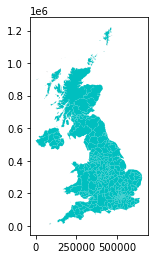

In [9]:
# Read the Local Authorities SHP file into a geopandas GeoDataFrame
authority_shp = gpd.read_file(r'C:\Users\Jonny.Lankfer\OneDrive - Global\Documents\Proximity\Workflow\Workflow Inputs\Lower Authority\LAD_MAY_2022_UK_BFE_V3.shp')

# Print the resulting DataFrame
display(authority_shp)

# Draw map of authorities in UK
%matplotlib inline
print('UK Local Authorities Map:')
authority_shp.plot(color='c')

In [10]:
# Merge the dataframes on 'Index value' and 'LAD22CD'
gdf_combined = authority_shp.merge(ethnicity_grouped[['Index value', 'Sum value']], left_on='LAD22CD', right_on='Index value')

# Print the resulting DataFrame
display(gdf_combined)

,LAD22CD,LAD22NM,BNG_E,BNG_N,LONG,LAT,GlobalID,geometry,Index value,Sum value
0,E06000001,Hartlepool,447160,531474,-1.27018,54.6761,2efc9848-300e-4ef3-a36e-58d6856b9817,"POLYGON ((447213.900 537036.104, 447228.798 53...",E06000001,1.72
1,E06000002,Middlesbrough,451141,516887,-1.21099,54.5447,6d66b015-1f67-40f6-b239-15911fa03834,"POLYGON ((448489.897 522071.798, 448592.597 52...",E06000002,10.44
2,E06000003,Redcar and Cleveland,464361,519597,-1.00608,54.5675,a5a6513f-916e-4769-bed2-cd019d18719a,"POLYGON ((455525.931 528406.654, 455724.632 52...",E06000003,0.81
3,E06000004,Stockton-on-Tees,444940,518183,-1.30664,54.5569,14e8450b-7e7c-479a-a335-095ac2d9a701,"POLYGON ((444157.002 527956.304, 444165.898 52...",E06000004,4.57
4,E06000005,Darlington,428029,515648,-1.56835,54.5353,2f212ecf-daf5-4171-b9c6-825c0d33e5af,"POLYGON ((423496.602 524724.299, 423497.204 52...",E06000005,2.75
...,...,...,...,...,...,...,...,...,...,...
326,W06000020,Torfaen,327459,200480,-3.05101,51.6984,a9bfd875-581d-4b13-a88c-0be157037504,"POLYGON ((323898.201 211287.499, 324115.698 21...",W06000020,1.28
327,W06000021,Monmouthshire,337812,209231,-2.90280,51.7783,856d4586-ee01-46c6-8030-155676e72ec8,"MULTIPOLYGON (((345965.201 181030.700, 345944....",W06000021,1.28
328,W06000022,Newport,337897,187432,-2.89769,51.5823,9ded1cac-b393-4732-a068-4fbe1e8881cc,"POLYGON ((342211.900 194845.495, 342221.803 19...",W06000022,7.64
329,W06000023,Powys,302329,273255,-3.43531,52.3486,82c92ce3-674b-41dc-8702-31072fa0fc10,"POLYGON ((322392.901 334017.198, 322378.002 33...",W06000023,0.91


### Visualisations

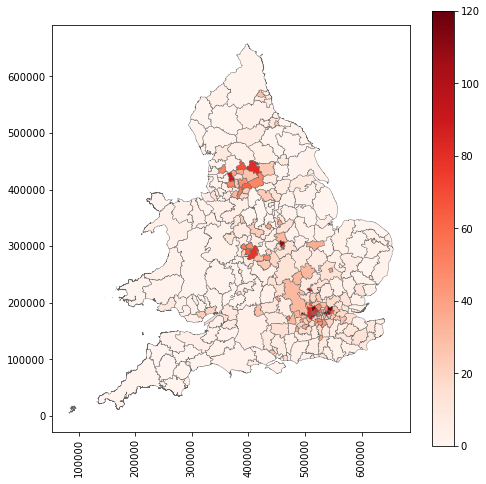

In [11]:
# Generate Heat Map of ethnicity % penentration by local authorities
fig, ax = plt.subplots(1, figsize=(8, 8))
plt.xticks(rotation=90)
gdf_combined.plot(column="Sum value", cmap="Reds", linewidth=0.4, ax=ax, edgecolor=".4")
bar_info = plt.cm.ScalarMappable(cmap="Reds", norm=plt.Normalize(vmin=0, vmax=120))
bar_info._A = []
cbar = fig.colorbar(bar_info)

,CP_Number,RoadNumber,geometry
0,51.0,A3111,"LINESTRING (90120.000 10710.000, 90320.000 105..."
1,52.0,A3112,"LINESTRING (90320.000 10530.000, 91650.000 108..."
2,53.0,A3111,"LINESTRING (90320.000 10530.000, 91430.000 109..."
3,54.0,A3110,"LINESTRING (91430.000 10900.000, 91650.000 108..."
4,55.0,A3110,"LINESTRING (91430.000 10900.000, 91650.000 108..."
...,...,...,...
18045,86078.0,A570,"LINESTRING (345270.000 404770.000, 344274.000 ..."
18046,86077.0,A570,"LINESTRING (340790.000 409500.000, 338324.000 ..."
18047,86076.0,A570,"LINESTRING (341339.000 408435.000, 341100.000 ..."
18048,86083.0,A570,"LINESTRING (338472.164 412251.306, 336245.164 ..."


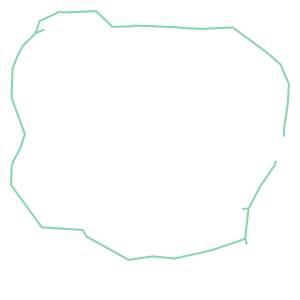

In [51]:
# add zoomed in map of London
# Read the Local Authorities SHP file into a geopandas GeoDataFrame
major_roads = gpd.read_file(r'C:\Users\Jonny.Lankfer\OneDrive - Global\Documents\Proximity\Workflow\Workflow Inputs\Major Roads\major-roads-link-network2015.shp')
# Print the resulting DataFrame
display(major_roads)

# Draw map of authorities in UK
# %matplotlib inline
# print('UK Major Roads:')
# major_roads.plot(color='c')

# selecting rows relevant to London boundary (M25) based on condition
m25_roads = major_roads[major_roads['RoadNumber'] == 'M25']

#Generate M25 spatial object from PolyLines 
m25 = m25_roads['geometry'].apply(lambda x: LineString(x))
m25_combined = linemerge(list(m25))

# Print spatial boundary
display(m25_combined)

In [30]:
# Create a bounding box around the M25 LineString
bbox = box(*m25_combined.bounds)

# Filter the GeoDataFrame to only include rows that intersect with the bounding box
gdf_filtered = gdf_combined[gdf_combined.intersects(bbox)]

# Print the resulting GeoDataFrame 
display(gdf_filtered)

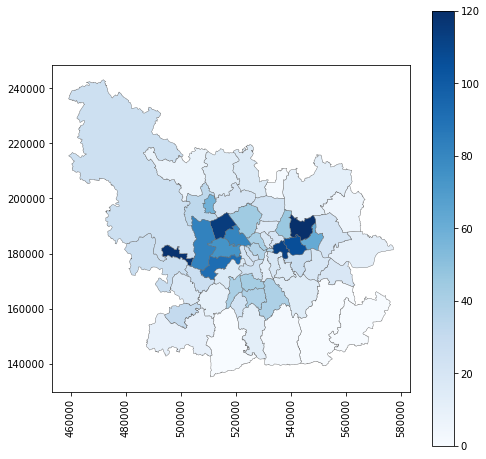

In [56]:
# Generate Heat Map of ethnicity % penentration by local authorities, filtered to London Local Authories that are within, or intersect the M25
fig, ax = plt.subplots(1, figsize=(8, 8))
plt.xticks(rotation=90)
gdf_filtered.plot(column="Sum value", cmap="Blues", linewidth=0.4, ax=ax, edgecolor=".4")
bar_info = plt.cm.ScalarMappable(cmap="Blues", norm=plt.Normalize(vmin=0, vmax=120))
bar_info._A = []
cbar = fig.colorbar(bar_info)